# Importing Required Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
import keras_tuner as kt
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Multi GPU strategy with TensorFlow

In [2]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 2


In [3]:
PATH = '/kaggle/input/dog-breed-identification'
NUM_CHANNEL = 3
INPUT_SHAPE = 256
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# Data Preprocessing

ImageDatastore to read files and feeds into the model during training

In [4]:
class ImageDatastore:
    
    def __init__(self, path, csv, output_shape, train_val_test):
        self.path = path
        self.csv = csv
        self.output_shape = output_shape
        self.train_val_test = train_val_test
        self.image_paths, self.labels = self.get_files_and_labels()
        
    def get_files_and_labels(self):
        image_paths = [os.path.join(self.path, path) + '.jpg' for path in self.csv.index]
        if self.train_val_test == 'test':
            labels = ['' for i in range(len(image_paths))]
        else:
            labels = pd.get_dummies(self.csv.breed).astype('uint8').to_numpy()
        return image_paths, labels
    
    def __call__(self):
        pairs = list(zip(self.image_paths, self.labels))
        for image_path, label in pairs:
            image = cv2.imread(image_path)
            image = cv2.resize(image, self.output_shape)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.train_val_test == 'test':
                yield image
            else:
                yield image, label

CustomCallback to patiently reduce the learning rate, then stops at the last patience.

In [27]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor="loss", factor=0.5, patience=0, min_lr=0.01):
        super(CustomCallback, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.job = 0

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        if 'loss' in self.monitor:
            self.best = np.inf
        else:
            self.best = -1

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if 'loss' in self.monitor and current < self.best:
            self.best = current
            self.wait = 0
        elif 'acc' in self.monitor and  current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.job == 0:
                    lr = float(K.get_value(self.model.optimizer.learning_rate))
                    new_lr = lr * self.factor
                    if new_lr < self.min_lr:
                        new_lr = self.min_lr
                        self.job = 1
                    K.set_value(self.model.optimizer.lr, new_lr)
                    self.wait = 0
                    print(f"\nLearning rate reduced from {'{:.3g}'.format(lr)} to {'{:.3g}'.format(new_lr)}")
                elif self.job == 1:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")

In [6]:
train_df = pd.read_csv(os.path.join(PATH, 'labels.csv'), index_col='id')
train_df.head()

,breed
id,
000bec180eb18c7604dcecc8fe0dba07,boston_bull
001513dfcb2ffafc82cccf4d8bbaba97,dingo
001cdf01b096e06d78e9e5112d419397,pekinese
00214f311d5d2247d5dfe4fe24b2303d,bluetick
0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
NUM_CLASS = train_df.breed.nunique()

In [8]:
val_ratio = 0.2
num_sapmle = int(len(train_df) * val_ratio / NUM_CLASS)

In [9]:
val_df = pd.concat([train_df[train_df.breed == lbl].sample(num_sapmle) for lbl in train_df.breed.unique()], axis=0)
val_df = val_df.sample(frac=1)

train_df = train_df.drop(val_df.index)

In [10]:
train_ds = ImageDatastore(os.path.join(PATH, 'train'), train_df, (INPUT_SHAPE, INPUT_SHAPE), 'train')
val_ds = ImageDatastore(os.path.join(PATH, 'train'), val_df, (INPUT_SHAPE, INPUT_SHAPE), 'val')

Data augmentation with random flip, rotation and zoom. 

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

tf.Data for [better performance](https://www.tensorflow.org/guide/data_performance)  

In [12]:
OUTPUT_SIGNATURE = (tf.TensorSpec(shape=(INPUT_SHAPE, INPUT_SHAPE, NUM_CHANNEL), dtype='uint8'), tf.TensorSpec(shape=(NUM_CLASS), dtype='uint8'))

train = tf.data.Dataset.from_generator(generator=train_ds, output_signature=OUTPUT_SIGNATURE)
train = tf.data.Dataset.range(1).interleave(lambda _: train, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=True).map(lambda X, y: (data_augmentation(X, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val = tf.data.Dataset.from_generator(generator=val_ds, output_signature=OUTPUT_SIGNATURE)
val = tf.data.Dataset.range(1).interleave(lambda _: val, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Building a Model

Method to build model with hyper-parameters optimization features

In [29]:
def build_model(hp):

    input_shape = (INPUT_SHAPE, INPUT_SHAPE, NUM_CHANNEL)

    base = tf.keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
    base.trainable=False
    base.training=False

    inputs = tf.keras.Input(shape=input_shape)
    
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x)
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x=tf.keras.layers.Dense(hp_units)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    hp_act = hp.Choice('activation', values=['relu', 'tanh'])
    x=tf.keras.layers.Activation(hp_act)(x)
    
    hp_drop = hp.Float('rate', min_value=0.0, max_value=0.5, step=0.1)
    x=tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(NUM_CLASS, activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
    )
    return model

In [30]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    distribution_strategy=strategy)

In [31]:
tuner.search(train, epochs=50, validation_data=val)

In [32]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is {best_hps.get('units')},
the optimal activation for the first densely-connected is {best_hps.get('activation')}
and the optimal rate for dropout is {best_hps.get('rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 512,
the optimal activation for the first densely-connected is tanh
and the optimal rate for dropout is 0.0.



Create the model with best hyper-parameters

In [33]:
with strategy.scope():
    model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                           

In [34]:
history = model.fit(
    train,
    epochs=1000,
    validation_data=val,
    callbacks=[CustomCallback(monitor='val_accuracy', factor=0.5, patience=10, min_lr=2e-6)]
)

Epoch 1/1000
127/127 [==============================] - 19s 86ms/step - loss: 2.9538 - accuracy: 0.3024 - val_loss: 1.0593 - val_accuracy: 0.7409
Epoch 2/1000
127/127 [==============================] - 9s 68ms/step - loss: 1.5792 - accuracy: 0.5748 - val_loss: 0.8371 - val_accuracy: 0.7802
Epoch 3/1000
127/127 [==============================] - 9s 68ms/step - loss: 1.1669 - accuracy: 0.6881 - val_loss: 0.7771 - val_accuracy: 0.7797
Epoch 4/1000
127/127 [==============================] - 9s 68ms/step - loss: 0.8640 - accuracy: 0.7774 - val_loss: 0.7635 - val_accuracy: 0.7732
Epoch 5/1000
127/127 [==============================] - 9s 67ms/step - loss: 0.6492 - accuracy: 0.8385 - val_loss: 0.7473 - val_accuracy: 0.7782
Epoch 6/1000
127/127 [==============================] - 9s 67ms/step - loss: 0.4899 - accuracy: 0.8847 - val_loss: 0.7528 - val_accuracy: 0.7797
Epoch 7/1000
127/127 [==============================] - 9s 67ms/step - loss: 0.3539 - accuracy: 0.9259 - val_loss: 0.7486 - val_a

Plotting metrics

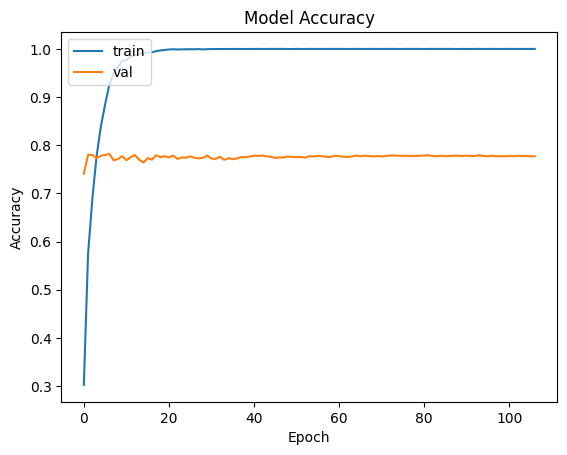

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

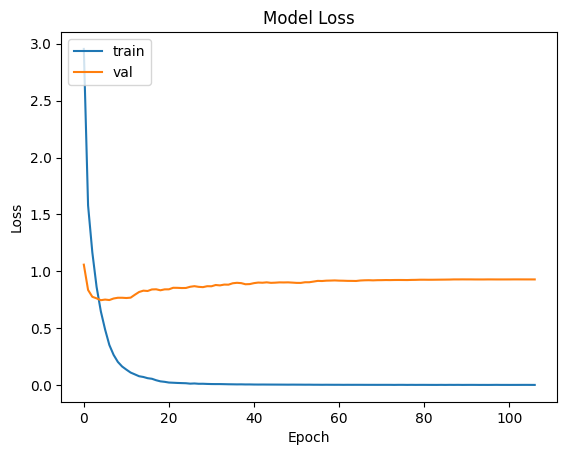

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Submission

In [21]:
sub_test_df = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv', index_col='id')

In [22]:
sub_test_ds = ImageDatastore(os.path.join(PATH, 'test'), sub_test_df, (INPUT_SHAPE, INPUT_SHAPE), 'test')

In [23]:
SUB_OUTPUT_SIGNATURE = (tf.TensorSpec(shape=(INPUT_SHAPE, INPUT_SHAPE, NUM_CHANNEL), dtype='uint8'))
sub_test = tf.data.Dataset.from_generator(generator=sub_test_ds, output_signature=SUB_OUTPUT_SIGNATURE)
sub_test = tf.data.Dataset.range(1).interleave(lambda _:sub_test, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE, drop_remainder=False).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
pred = model.predict(sub_test)

162/162 [==============================] - 16s 83ms/step


In [38]:
sub_test_df.iloc[:] = pred

In [39]:
sub_test_df.to_csv(os.path.join('/kaggle', 'working', 'submission.csv'))
sub_test_df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,1.118055e-06,4.797894e-07,4.454193e-09,5.112595e-09,6.055856e-06,4.072621e-08,1.484389e-09,2.347966e-08,1.728600e-07,7.576522e-08,...,9.326194e-09,1.657798e-07,3.178040e-08,5.879478e-09,6.403674e-08,7.029091e-08,7.723491e-09,1.330555e-08,3.827223e-08,1.809225e-08
00102ee9d8eb90812350685311fe5890,9.796566e-10,1.071677e-08,1.456325e-09,1.909555e-09,1.958279e-09,6.337517e-10,1.444907e-08,1.821925e-10,4.901127e-08,3.927044e-11,...,4.930864e-10,6.652145e-10,9.350107e-10,1.966044e-10,2.960522e-09,7.981047e-11,4.859186e-11,1.624871e-09,4.651254e-12,3.387038e-09
0012a730dfa437f5f3613fb75efcd4ce,2.733007e-08,2.968495e-05,2.413601e-06,1.187139e-08,2.412476e-09,1.861233e-09,3.727754e-09,2.289535e-09,1.353856e-07,2.366439e-08,...,3.737517e-08,1.870954e-09,5.580625e-07,1.764211e-09,2.098675e-04,1.751985e-04,2.479004e-08,2.500359e-08,2.742520e-09,1.047931e-07
001510bc8570bbeee98c8d80c8a95ec1,6.864122e-04,9.468748e-04,5.207616e-06,1.662397e-04,5.203609e-04,1.113940e-03,6.699802e-06,7.118917e-04,2.470675e-05,4.128327e-05,...,1.392944e-06,3.073686e-06,3.497049e-05,4.044652e-06,2.412274e-06,2.815679e-06,6.810898e-06,1.336660e-04,1.243643e-06,2.142159e-04
001a5f3114548acdefa3d4da05474c2e,2.275470e-05,1.490990e-08,1.374164e-09,3.745429e-10,2.318846e-08,1.535007e-09,2.737371e-08,1.899042e-08,2.070591e-07,2.301249e-08,...,2.986461e-08,1.797174e-08,1.199782e-08,2.605217e-07,7.896192e-09,7.441267e-09,1.027112e-07,4.490481e-09,1.087798e-08,8.202495e-08
